First, we stack spectra to get a (scaled) average spectrum, weighted equally between the fits files (scaled first then added). 

In [296]:
from time import perf_counter as clock
from pathlib import Path
from urllib import request
import numpy as np
from astropy.io import fits
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

In [297]:
"""Choosing a list of .fits files to stack:

For testing purposes we select the high dor cluster from hierarchical clustering and form a list, data, in which each element is a list of 
[wave, flux, ivar] for one spectrum

"""

files = ["cluster_results/k-means_clusters.csv", "cluster_results/gmm_clusters.csv", "cluster_results/hierarchical_clusters.csv"]
filename = files[2]  # selecting hierarchical for now
clusters = pd.read_csv(filename)
two = clusters[clusters["Cluster"]==2]["SDSS_ID"].tolist() # list of file names selecting cluster 2
one = clusters[clusters["Cluster"]==1]["SDSS_ID"].tolist() # selecting 1
zero = clusters[clusters["Cluster"]==0]["SDSS_ID"].tolist() # selecting 0


# Now we also try using actual DoR ranges
all = pd.read_csv("data/E-INSPIRE_I_master_catalogue.csv")

high = all[all['DoR']>0.6]
high_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(high['plate'], high['mjd'], high['fiberid'])]

med1 = all[all['DoR']<0.6]
med = med1[med1['DoR']>0.3]
med_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(med['plate'], med['mjd'], med['fiberid'])]

low = all[all['DoR']<0.3]
low_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(low['plate'], low['mjd'], low['fiberid'])]

spectra = high_ids  # change to whichever you want

In [298]:
data = []

def clean_and_normalize_spectrum(wave, flux, ivar):
    # Remove NaN and inf values
    good_idx = np.isfinite(flux) & np.isfinite(ivar)
    wave, flux, ivar = wave[good_idx], flux[good_idx], ivar[good_idx]
    
    
    # Simple normalization by median flux
    median_flux = np.median(flux)
    
    
    #normalize by 5300 instead
    area = wave[wave>5200]
    area = area[area<5400]
    if len(area)<1:
        print("ERROR")
    
    normalizing_wave = np.median(area)

    flux = flux / normalizing_wave
    ivar = ivar * (normalizing_wave ** 2)

    return wave, flux, ivar

def load_spectrum(filename):
    with fits.open(filename) as hdul:
        coadd = hdul[1].data  # Extension 1 contains the spectrum
        flux = coadd['flux']
        loglam = coadd['loglam']
        ivar = coadd['ivar']
        specobj = hdul[2].data
        z = specobj['Z'][0]
        
        wavelength = 10**loglam
        wavelength *= 1/(1+z)
        wavelength, flux, ivar = clean_and_normalize_spectrum(wavelength, flux, ivar)
        
        return wavelength, flux, ivar
    
def parse_sdss_filename(filename):
    # Extract numbers using regex
    match = re.match(r'spec-(\d{4})-(\d{5})-(\d{4})\.fits', filename)
    if match:
        plate, mjd, fiber = map(int, match.groups())
        return plate, mjd, fiber
    return None, None, None

catalogue = pd.read_csv('data/E-INSPIRE_I_master_catalogue.csv')
mgfe = []
vdisps = []

for filename in spectra:
    wave, flux, ivar = load_spectrum("fits_shortlist/"+filename) # data[0]
    plate, mjd, fiber = parse_sdss_filename(filename)
    
    matching_row = catalogue[(catalogue['plate'] == plate) & 
                       (catalogue['mjd'] == mjd) & 
                       (catalogue['fiberid'] == fiber)]
    mgfe.append(float(matching_row['MgFe']))
    vd= matching_row["velDisp_ppxf_res"]
    vdisps.append(float(vd))
    
    data.append([wave, flux, ivar])


mgfe_avg = round(np.mean(mgfe), 1)  # Rounds to nearest 0.1

print(data[0][0][0]) # shortest wavelength for first spectrum
print(data[1][0][0])  #"" "" for second spectrum
# Clearly we will need to do some aligning ... ?

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_23969/2794034523.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mgfe.append(float(matching_row['MgFe']))
/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_23969/2794034523.py:62: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vdisps.append(float(vd))


3527.038
3417.1897


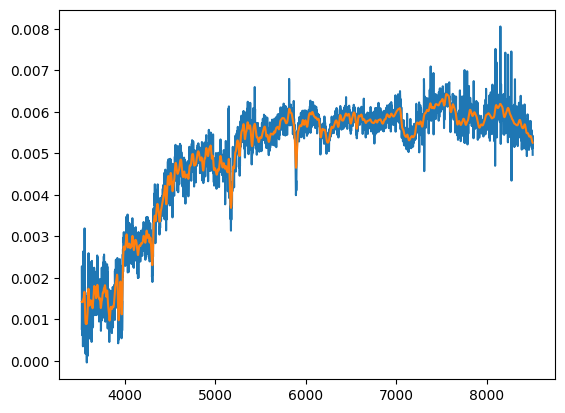

In [299]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
c = 299792.458 # speed of light in km/s


def calculate_sigma_diff(wave, sigma_gal, sigma_fin):
    # For log-binned spectra:
    ln_wave = np.log(wave)
    d_ln_wave = (ln_wave[-1] - ln_wave[0])/(len(wave) - 1)  # log step size
    velscale = c * d_ln_wave  # Velocity scale in km/s per pixel
    
    wave_ref = np.mean(wave)  # Use mean wavelength as reference
    sigma_gal_pxl = sigma_gal / velscale  # Convert km/s to pixels
    sigma_fin_pxl = sigma_fin / velscale
    
    sigma_diff = np.sqrt(sigma_fin_pxl**2 - sigma_gal_pxl**2)
    
    return sigma_diff

def smooth_spectrum_to_sigma(wave, flux, sigma_gal, sigma_fin):
    if sigma_fin <= sigma_gal:
        return flux
        
    sigma_diff = calculate_sigma_diff(wave, sigma_gal, sigma_fin)
    
    # Apply smoothing with single sigma_diff value
    smoothed_flux = gaussian_filter1d(flux, sigma_diff)
    # print(f"Original sigma: {sigma_gal:.2f} km/s, Smoothing kernel: {sigma_diff:.2f} pixels")
    return smoothed_flux

def smooth(data, sigma_gals, sigma_fin):
    smoothed_data = []
    
    for (wave, flux, ivar), sigma_gal in zip(data, sigma_gals):
        smoothed_flux = smooth_spectrum_to_sigma(wave, flux, sigma_gal, sigma_fin)
        smoothed_data.append([wave, smoothed_flux, ivar])
        
    return smoothed_data

sigma_fin = max(vdisps)
smoothed = smooth(data, vdisps, sigma_fin)

plt.plot(data[0][0], data[0][1])
plt.plot(smoothed[0][0], smoothed[0][1])

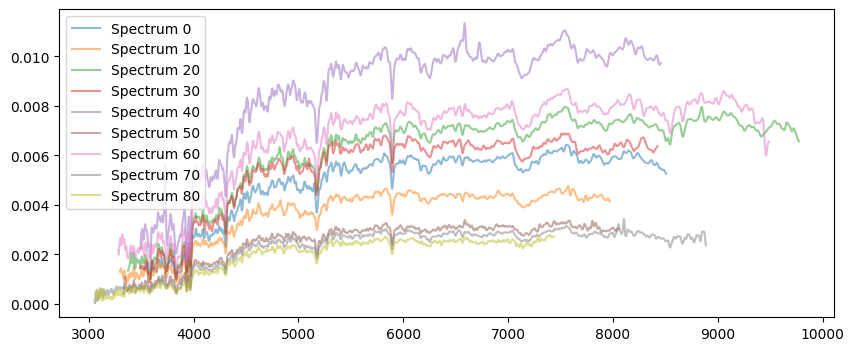

In [300]:
# Plot all smoothed spectra together
plt.figure(figsize=(10, 4))
for i, spectrum in enumerate(smoothed):
    if i%10 ==0:  # just want to plot a few not all...
        #plt.plot(data[i][0], data[i][1])
        plt.plot(spectrum[0], spectrum[1], label=f'Spectrum {i}', alpha=0.5)

plt.legend()
plt.show()

In [301]:
"""

Linear binning resampling

from scipy import interpolate

def resample_spectrum(wave, flux, ivar, new_wave):
    # Interpolate flux onto new wavelength grid
    f = interpolate.interp1d(wave, flux, bounds_error=False, fill_value=0)
    new_flux = f(new_wave)
    
    # Interpolate ivar (need to handle this carefully)
    f_ivar = interpolate.interp1d(wave, ivar, bounds_error=False, fill_value=0)
    new_ivar = f_ivar(new_wave)
    
    return new_flux, new_ivar
    
# Create common wavelength grid
wave_min = max([smoothed[i][0][0] for i in range(len(smoothed))])  # Maximum of all minimum wavelengths
wave_max = min([smoothed[i][0][-1] for i in range(len(smoothed))]) # Minimum of all maximum wavelengths
wave_common = np.linspace(wave_min, wave_max, num=3828)

# Resample all spectra
resampled_data = []
for spectrum in smoothed:
   new_flux, new_ivar = resample_spectrum(spectrum[0], spectrum[1], spectrum[2], wave_common)
   resampled_data.append([wave_common, new_flux, new_ivar])"""

'\n\nLinear binning resampling\n\nfrom scipy import interpolate\n\ndef resample_spectrum(wave, flux, ivar, new_wave):\n    # Interpolate flux onto new wavelength grid\n    f = interpolate.interp1d(wave, flux, bounds_error=False, fill_value=0)\n    new_flux = f(new_wave)\n    \n    # Interpolate ivar (need to handle this carefully)\n    f_ivar = interpolate.interp1d(wave, ivar, bounds_error=False, fill_value=0)\n    new_ivar = f_ivar(new_wave)\n    \n    return new_flux, new_ivar\n    \n# Create common wavelength grid\nwave_min = max([smoothed[i][0][0] for i in range(len(smoothed))])  # Maximum of all minimum wavelengths\nwave_max = min([smoothed[i][0][-1] for i in range(len(smoothed))]) # Minimum of all maximum wavelengths\nwave_common = np.linspace(wave_min, wave_max, num=3828)\n\n# Resample all spectra\nresampled_data = []\nfor spectrum in smoothed:\n   new_flux, new_ivar = resample_spectrum(spectrum[0], spectrum[1], spectrum[2], wave_common)\n   resampled_data.append([wave_common, n

In [302]:
from scipy import interpolate

# resample using logbinning instead
def resample_spectrum(wave, flux, ivar, new_wave):
    # Interpolate flux onto new wavelength grid
    f = interpolate.interp1d(wave, flux, bounds_error=False, fill_value=0)
    new_flux = f(new_wave)
    
    # Interpolate ivar (need to handle this carefully)
    f_ivar = interpolate.interp1d(wave, ivar, bounds_error=False, fill_value=0)
    new_ivar = f_ivar(new_wave)
    
    return new_flux, new_ivar
    
# Create common wavelength grid
wave_min = max([smoothed[i][0][0] for i in range(len(smoothed))])  # Maximum of all minimum wavelengths
wave_max = min([smoothed[i][0][-1] for i in range(len(smoothed))]) # Minimum of all maximum wavelengths

# Create logarithmically spaced wavelength grid
# Method 1: using np.logspace
wave_common = np.logspace(np.log10(wave_min), np.log10(wave_max), num=3828)

# OR Method 2: using np.exp(np.linspace)
# wave_common = np.exp(np.linspace(np.log(wave_min), np.log(wave_max), num=3828))


# Resample all spectra
resampled_data = []
for spectrum in smoothed:
   new_flux, new_ivar = resample_spectrum(spectrum[0], spectrum[1], spectrum[2], wave_common)
   resampled_data.append([wave_common, new_flux, new_ivar])
   
dlambda = np.diff(wave_common)
dlambda_over_lambda = dlambda / wave_common[:-1]
print("Δλ/λ values:", dlambda_over_lambda[:5])

Δλ/λ values: [0.00018559 0.00018502 0.00018559 0.00018502 0.00018559]


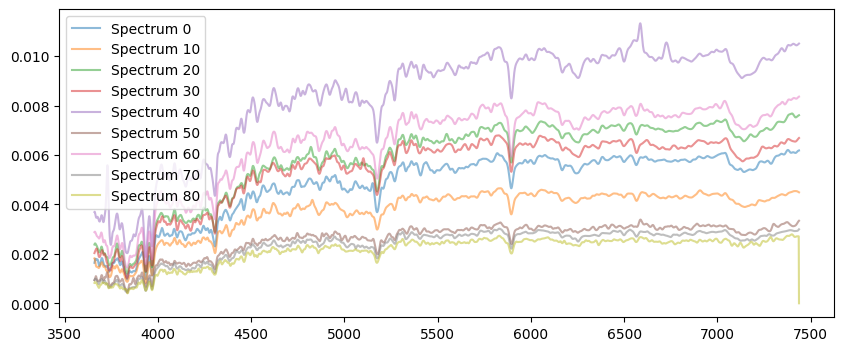

In [313]:
"""plt.figure(figsize=(10, 4))
plt.plot(smoothed[0][0], smoothed[0][1], label='Original', alpha=0.5)
plt.plot(resampled_data[0][0], resampled_data[0][1], label='Resampled', alpha=0.5)
plt.legend()

plt.title('First Spectrum: Original vs Resampled')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(smoothed[1][0], smoothed[1][1], label='Original', alpha=0.5)
plt.plot(resampled_data[1][0], resampled_data[1][1], label='Resampled', alpha=0.5)
plt.legend()
plt.title('Second Spectrum: Original vs Resampled')
plt.show()

# Print wavelength ranges
print(f"Common wavelength range: {wave_min:.2f} to {wave_max:.2f} Å")"""


# Plot all smoothed spectra together
plt.figure(figsize=(10, 4))
for i, spectrum in enumerate(resampled_data):
    if i%10 ==0:  # just want to plot a few not all...
        #plt.plot(data[i][0], data[i][1])
        plt.plot(spectrum[0], spectrum[1], label=f'Spectrum {i}', alpha=0.5)

plt.legend()
plt.show()


In [304]:
def safe_combine_ivar(*ivars):
    ivar_stack = np.stack(ivars)
    
    # Create mask for any invalid values
    mask = np.any((ivar_stack == 0) | np.isinf(ivar_stack), axis=0)
    combined = np.zeros_like(ivars[0])
    
    # Combine valid values
    valid = ~mask
    if np.any(valid):
        # Sum of 1/ivar for valid points
        sum_inv_ivar = np.sum(1.0/ivar_stack[:, valid], axis=0)
        combined[valid] = 1.0 / sum_inv_ivar
    
    return combined


def combine_spectra(aligned_spectra):
    # Extract components
    wavelength = aligned_spectra[0][0]  # All wavelengths should be the same
    fluxes = [spec[1] for spec in aligned_spectra]
    ivars = [spec[2] for spec in aligned_spectra]
    
    # Calculate mean flux
    combined_flux = np.mean(fluxes, axis=0)
    
    # Combine inverse variances
    combined_ivar = safe_combine_ivar(*ivars)
    
    return wavelength, combined_flux, combined_ivar

def safe_errors(stacked_ivar):
    errors = np.zeros_like(stacked_ivar)
    valid = (stacked_ivar > 0) & np.isfinite(stacked_ivar)
    errors[valid] = 1.0 / np.sqrt(stacked_ivar[valid])
    return errors

wavelength, flux, combined_ivar = combine_spectra(resampled_data)
#wavelength, flux, combined_ivar = combine_spectra(smoothed)

errors = safe_errors(combined_ivar)  # use combined_ivar instead of ivar


Now we fit ppxf as normal. I use example "ppxf_example)gas_sdss_tied.ipynb" for guidance / example. 

In [305]:
lam_gal = wavelength
ln_lam_gal = np.log(lam_gal)  # Natural logarithm
d_ln_lam_gal = (ln_lam_gal[-1] - ln_lam_gal[0])/(ln_lam_gal.size - 1)  # Use full lam range for accuracy
velscale = c*d_ln_lam_gal                   # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
factor = 0.01635
noise = np.full_like(flux, factor)           # Assume constant noise per pixel here 


"""
PLAY WITH FACTOR HERE TO CHANGE CHISQUARED TO ROUGHLY 1
"""

'\nPLAY WITH FACTOR HERE TO CHANGE CHISQUARED TO ROUGHLY 1\n'

In [306]:
""" USE CHIARA's FORMULA HERE for smoothing"""

" USE CHIARA's FORMULA HERE for smoothing"

In [307]:
dlam_gal = np.gradient(lam_gal)  # Size of every pixel in Angstroms

hdul = fits.open('fits_shortlist/spec-0273-51957-0005.fits')
coadd = hdul[1].data 
wdisp = coadd['wdisp']  # assuming that the wdisp is constant between the two spectra for now.

fwhm_gal = 2.355*wdisp*dlam_gal 

In [308]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

In [309]:
basename = f"spectra_{sps_name}_9.0.npz"
ppxf_dir = Path(lib.__file__).parent
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

fwhm_gal_dic = {"lam": lam_gal, "fwhm": fwhm_gal}
sps = lib.sps_lib(filename, velscale, fwhm_gal_dic)

stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)


lam_range_gal = np.array([np.min(lam_gal), np.max(lam_gal)]) 
gas_templates, gas_names, gas_wave = \
    util.emission_lines(sps.ln_lam_temp, lam_range_gal, fwhm_gal_dic)
templates = np.column_stack([stars_templates, gas_templates])
n_temps = stars_templates.shape[1]

Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726'
 '[OII]3729' '[SII]6716' '[SII]6731' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


In [310]:
component = [0]*n_temps  # Single stellar kinematic component=0 for all templates
component += [1]*len(gas_names)   # First 6 gas templates 
component = np.array(component)
moments = [2]*len(np.unique(component))  # Now this will create only 2 sets of moments (stars and gas)

print(component.shape)
print(templates.shape)
vel0 = c * np.log(1)  # redshift meant to be in here too, using 1 as default?
sol = [vel0, 200]
start = [sol for j in range(len(moments))]  # adopt the same starting value for both gas and stars

(169,)
(18314, 169)


 Best Fit:       Vel     sigma
 comp.  0:        84       448
 comp.  1:       101       550
chi2/DOF: 7.552e-06; DOF: 3814; degree = -1; mdegree = 10
method = capfit; Jac calls: 10; Func calls: 155; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 16/169
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10  0.0004075     0.097     101   550
Comp:  1                    H9      0.000     0.097     101   550
Comp:  1                    H8   0.002605     0.098     101   550
Comp:  1                  Heps      0.000      0.39     101   550
Comp:  1                Hdelta      0.000     0.097     101   550
Comp:  1                Hgamma  0.0003801     0.097     101   550
Comp:  1                 Hbeta   0.002769     0.097     101   550
Comp:  1                Halpha   0.003140      0.13     101   550
Comp:

Text(0.5, 1.0, 'pPXF fit with emiles SPS templates')

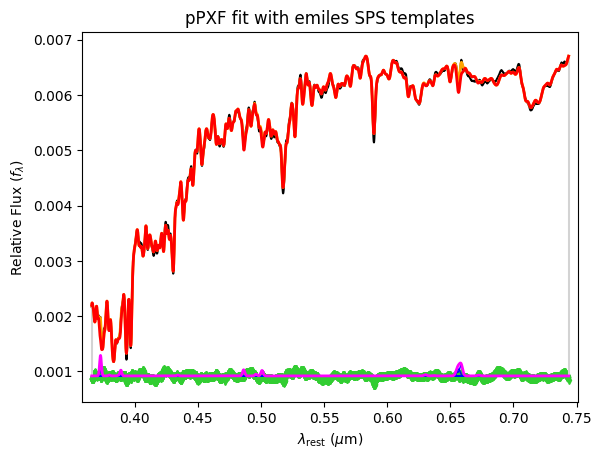

In [311]:
degree= -1
mdegree = 10
t = clock()

pp = ppxf(templates, flux, noise, velscale, start, plot=False, # changed "galaxy" to flux here
            moments=moments, degree=degree, mdegree=mdegree, 
            lam=lam_gal, component=component, 
            gas_component=component > 0, gas_names=gas_names,
            lam_temp=sps.lam_temp, clean = True)

print(f"Elapsed time in pPXF: {(clock() - t):.2f}")
pp.plot()
plt.title(f"pPXF fit with {sps_name} SPS templates")